In [2]:
import glob
import pandas as pd
import numpy as np

import os
import os.path as osp
import re

In [3]:
attack = "crownibp"

In [4]:
base_path = osp.join(os.getcwd(),"results")
attack_folder =  f"attack_{attack}"
seeds = [str(i*111) for i in range(1,6)]
results_folder = os.path.join(base_path, attack_folder)

In [5]:
algorithms = ["draft","noise","fgsm","pgd","aae","crownibp"]
exclude_datasets = ["Dialysis","divorce","Pbc3","vlbw"]

In [6]:
# CI , IBS , NegLL
metric = "CI"

ascending = False if metric=="CI" else True

In [15]:
def get_metric_excel_paths(base_path,metric):
    # Use glob to match all CI.xlsx files in seed_{number} folders
    pattern = os.path.join(base_path, "results_*", "*", "seed_*", f"{metric}.xlsx")
    metric_excel_paths = glob.glob(pattern)
    return metric_excel_paths

def read_metric_data(file_path):
    # Read the CI.xlsx file and extract epsilon and CI values
    df = pd.read_excel(file_path)
    if df.shape[1] != 2:
        raise ValueError(f"Unexpected format in {file_path}. Expected exactly two columns.")

    metric_name = df.columns[-1]
    df.columns = ['epsilon', metric_name]
    return df

def extract_metadata_from_path(path):
    # Extract dataset, algorithm, and attack method from the path
    parts = path.split(os.sep)
    attack_method = parts[-5].replace("attack_", "")
    algorithm = parts[-4].replace("results_", "")
    dataset = parts[-3]
    seed = int(parts[-2].replace("seed_", ""))
    return dataset, algorithm, attack_method, seed

def create_aggregated_dataframe(base_path,metric="CI"):
    # Get all CI.xlsx file paths
    ci_excel_files = get_metric_excel_paths(base_path,metric)
    
    # Dictionary to store dataframes by (dataset, algorithm) keys
    data_dict = {}
    
    # Process each CI.xlsx file
    for file_path in ci_excel_files:
        dataset, algorithm, attack_method, seed = extract_metadata_from_path(file_path)
        metric_data = read_metric_data(file_path)
        
        # Use (dataset, algorithm) as key
        key = (dataset, algorithm)
        
        # Initialize list for the key if not present
        if key not in data_dict:
            data_dict[key] = []
        
        # Append CI data to the list for that key
        data_dict[key].append(metric_data.set_index('epsilon'))
    
    # Dictionary to store aggregated dataframes
    aggregated_data = {}

    # Aggregate by dataset and algorithm
    for (dataset, algorithm), dfs in data_dict.items():
        # Concatenate along the columns to align by epsilon values and compute mean
        concatenated_df = pd.concat(dfs, axis=1)
        aggregated_df = concatenated_df.mean(axis=1).to_frame(name=(dataset, algorithm))
        aggregated_data[(dataset, algorithm)] = aggregated_df
    
    # Combine all aggregated dataframes into a single dataframe with multi-index columns
    final_df = pd.concat(aggregated_data.values(), axis=1)

    # Sort the columns by dataset and then by algorithm for a clean MultiIndex
    final_df = final_df.sort_index(axis=1, level=[0, 1])

    # Create a MultiIndex for the columns with levels: dataset and algorithm
    columns = pd.MultiIndex.from_tuples(final_df.columns, names=['Dataset', 'Algorithm'])
    final_df.columns = columns
    
    return final_df


In [73]:
final_df = create_aggregated_dataframe(results_folder,metric).reindex(columns=algorithms, level=1)

Automatic pdb calling has been turned ON


In [8]:
rename_dict = {"draft":"DRAFT","noise":"Noise","fgsm":"FGSM","pgd":"PGD","aae":"AAE-Cox","crownibp":"SAWAR"}
algorithms_renamed = list(rename_dict.values())

In [9]:
final_df = final_df.rename(columns=rename_dict, level=1)

In [10]:
final_df

Dataset       Aids2                                                    \
Algorithm     DRAFT     Noise      FGSM       PGD   AAE-Cox     SAWAR   
epsilon                                                                 
1.00       0.516171  0.512748  0.512274  0.506290  0.504278  0.565083   
0.90       0.518856  0.515408  0.516062  0.509438  0.508180  0.567560   
0.80       0.521990  0.518006  0.520122  0.513243  0.507119  0.568165   
0.70       0.525367  0.520598  0.523154  0.518239  0.505639  0.568705   
0.60       0.527119  0.524820  0.525596  0.522718  0.504769  0.569393   
0.50       0.530305  0.528724  0.531721  0.528103  0.501307  0.569595   
0.40       0.535851  0.534578  0.537419  0.535079  0.499323  0.569980   
0.30       0.550973  0.548266  0.549665  0.552215  0.504294  0.570123   
0.20       0.566007  0.567678  0.565337  0.566554  0.510153  0.569808   
0.10       0.572014  0.570693  0.568747  0.569236  0.561045  0.569725   
0.05       0.571586  0.570010  0.567622  0.567601  0.573241  0.569444   
0.00       0.570239  0.568971  0.566401  0.566769  0.572714  0.569427   

Dataset   Framingham                                ...    stagec            \
Algorithm      DRAFT     Noise      FGSM       PGD  ...      FGSM       PGD   
epsilon                                             ...                       
1.00        0.617694  0.606083  0.582500  0.539290  ...  0.329412  0.341176   
0.90        0.633600  0.621960  0.597633  0.559405  ...  0.346078  0.351961   
0.80        0.649016  0.637449  0.611145  0.582296  ...  0.367647  0.381373   
0.70        0.663240  0.652602  0.625740  0.604630  ...  0.389216  0.399020   
0.60        0.675746  0.666481  0.641013  0.626535  ...  0.415686  0.418627   
0.50        0.687681  0.678768  0.654618  0.647438  ...  0.429412  0.431373   
0.40        0.699007  0.691243  0.670827  0.668528  ...  0.443137  0.442157   
0.30        0.708429  0.702689  0.691317  0.692581  ...  0.470588  0.469608   
0.20        0.716074  0.712686  0.707896  0.710398  ...  0.488235  0.490196   
0.10        0.719816  0.717816  0.715446  0.717141  ...  0.501961  0.496078   
0.05        0.720755  0.718713  0.715115  0.716621  ...  0.502941  0.498039   
0.00        0.721612  0.719291  0.714935  0.716809  ...  0.509804  0.504902   

Dataset                            zinc                                \
Algorithm   AAE-Cox     SAWAR     DRAFT     Noise      FGSM       PGD   
epsilon                                                                 
1.00       0.393137  0.393137  0.261675  0.318190  0.376650  0.383926   
0.90       0.397059  0.400980  0.270305  0.328426  0.403299  0.406345   
0.80       0.397059  0.412745  0.283587  0.342978  0.439255  0.442978   
0.70       0.410784  0.425490  0.296277  0.365651  0.490017  0.495262   
0.60       0.416667  0.436275  0.317343  0.400508  0.556599  0.558883   
0.50       0.408824  0.460784  0.354653  0.466159  0.625550  0.632487   
0.40       0.404902  0.488235  0.440271  0.561591  0.685025  0.695262   
0.30       0.429412  0.505882  0.578680  0.661083  0.737479  0.740525   
0.20       0.468627  0.534314  0.711591  0.734349  0.761929  0.769882   
0.10       0.522549  0.543137  0.755499  0.765821  0.780203  0.778088   
0.05       0.543137  0.548039  0.765228  0.773096  0.782149  0.779611   
0.00       0.540196  0.557843  0.770220  0.776311  0.783249  0.780711   

Dataset                        
Algorithm   AAE-Cox     SAWAR  
epsilon                        
1.00       0.226481  0.667090  
0.90       0.230880  0.725465  
0.80       0.228257  0.763367  
0.70       0.235618  0.785195  
0.60       0.233841  0.784602  
0.50       0.248985  0.784941  
0.40       0.264975  0.780626  
0.30       0.306261  0.778342  
0.20       0.444670  0.778426  
0.10       0.723858  0.775973  
0.05       0.754484  0.776058  
0.00       0.759306  0.774450  

[12 rows x 60 columns]

In [11]:
final_df[['zinc']]

Dataset        zinc                                                  
Algorithm     DRAFT     Noise      FGSM       PGD   AAE-Cox     SAWAR
epsilon                                                              
1.00       0.261675  0.318190  0.376650  0.383926  0.226481  0.667090
0.90       0.270305  0.328426  0.403299  0.406345  0.230880  0.725465
0.80       0.283587  0.342978  0.439255  0.442978  0.228257  0.763367
0.70       0.296277  0.365651  0.490017  0.495262  0.235618  0.785195
0.60       0.317343  0.400508  0.556599  0.558883  0.233841  0.784602
0.50       0.354653  0.466159  0.625550  0.632487  0.248985  0.784941
0.40       0.440271  0.561591  0.685025  0.695262  0.264975  0.780626
0.30       0.578680  0.661083  0.737479  0.740525  0.306261  0.778342
0.20       0.711591  0.734349  0.761929  0.769882  0.444670  0.778426
0.10       0.755499  0.765821  0.780203  0.778088  0.723858  0.775973
0.05       0.765228  0.773096  0.782149  0.779611  0.754484  0.776058
0.00       0.770220  0.776311  0.783249  0.780711  0.759306  0.774450

In [12]:
final_df[final_df==''] = np.NaN
final_df = final_df.astype(float)
final_df

Dataset       Aids2                                                    \
Algorithm     DRAFT     Noise      FGSM       PGD   AAE-Cox     SAWAR   
epsilon                                                                 
1.00       0.516171  0.512748  0.512274  0.506290  0.504278  0.565083   
0.90       0.518856  0.515408  0.516062  0.509438  0.508180  0.567560   
0.80       0.521990  0.518006  0.520122  0.513243  0.507119  0.568165   
0.70       0.525367  0.520598  0.523154  0.518239  0.505639  0.568705   
0.60       0.527119  0.524820  0.525596  0.522718  0.504769  0.569393   
0.50       0.530305  0.528724  0.531721  0.528103  0.501307  0.569595   
0.40       0.535851  0.534578  0.537419  0.535079  0.499323  0.569980   
0.30       0.550973  0.548266  0.549665  0.552215  0.504294  0.570123   
0.20       0.566007  0.567678  0.565337  0.566554  0.510153  0.569808   
0.10       0.572014  0.570693  0.568747  0.569236  0.561045  0.569725   
0.05       0.571586  0.570010  0.567622  0.567601  0.573241  0.569444   
0.00       0.570239  0.568971  0.566401  0.566769  0.572714  0.569427   

Dataset   Framingham                                ...    stagec            \
Algorithm      DRAFT     Noise      FGSM       PGD  ...      FGSM       PGD   
epsilon                                             ...                       
1.00        0.617694  0.606083  0.582500  0.539290  ...  0.329412  0.341176   
0.90        0.633600  0.621960  0.597633  0.559405  ...  0.346078  0.351961   
0.80        0.649016  0.637449  0.611145  0.582296  ...  0.367647  0.381373   
0.70        0.663240  0.652602  0.625740  0.604630  ...  0.389216  0.399020   
0.60        0.675746  0.666481  0.641013  0.626535  ...  0.415686  0.418627   
0.50        0.687681  0.678768  0.654618  0.647438  ...  0.429412  0.431373   
0.40        0.699007  0.691243  0.670827  0.668528  ...  0.443137  0.442157   
0.30        0.708429  0.702689  0.691317  0.692581  ...  0.470588  0.469608   
0.20        0.716074  0.712686  0.707896  0.710398  ...  0.488235  0.490196   
0.10        0.719816  0.717816  0.715446  0.717141  ...  0.501961  0.496078   
0.05        0.720755  0.718713  0.715115  0.716621  ...  0.502941  0.498039   
0.00        0.721612  0.719291  0.714935  0.716809  ...  0.509804  0.504902   

Dataset                            zinc                                \
Algorithm   AAE-Cox     SAWAR     DRAFT     Noise      FGSM       PGD   
epsilon                                                                 
1.00       0.393137  0.393137  0.261675  0.318190  0.376650  0.383926   
0.90       0.397059  0.400980  0.270305  0.328426  0.403299  0.406345   
0.80       0.397059  0.412745  0.283587  0.342978  0.439255  0.442978   
0.70       0.410784  0.425490  0.296277  0.365651  0.490017  0.495262   
0.60       0.416667  0.436275  0.317343  0.400508  0.556599  0.558883   
0.50       0.408824  0.460784  0.354653  0.466159  0.625550  0.632487   
0.40       0.404902  0.488235  0.440271  0.561591  0.685025  0.695262   
0.30       0.429412  0.505882  0.578680  0.661083  0.737479  0.740525   
0.20       0.468627  0.534314  0.711591  0.734349  0.761929  0.769882   
0.10       0.522549  0.543137  0.755499  0.765821  0.780203  0.778088   
0.05       0.543137  0.548039  0.765228  0.773096  0.782149  0.779611   
0.00       0.540196  0.557843  0.770220  0.776311  0.783249  0.780711   

Dataset                        
Algorithm   AAE-Cox     SAWAR  
epsilon                        
1.00       0.226481  0.667090  
0.90       0.230880  0.725465  
0.80       0.228257  0.763367  
0.70       0.235618  0.785195  
0.60       0.233841  0.784602  
0.50       0.248985  0.784941  
0.40       0.264975  0.780626  
0.30       0.306261  0.778342  
0.20       0.444670  0.778426  
0.10       0.723858  0.775973  
0.05       0.754484  0.776058  
0.00       0.759306  0.774450  

[12 rows x 60 columns]

In [13]:
final_df.applymap(np.isnan).sum().sum()

C:\Users\lpott\AppData\Local\Temp\ipykernel_40752\2774236446.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  final_df.applymap(np.isnan).sum().sum()


0

In [14]:
best_per_dataset_rank = final_df.groupby(level=0,axis=1).rank(axis=1,na_option='bottom',method="average",ascending=ascending).reindex(columns=algorithms_renamed, level=1)
best_per_dataset_rank

C:\Users\lpott\AppData\Local\Temp\ipykernel_40752\3915878950.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  best_per_dataset_rank = final_df.groupby(level=0,axis=1).rank(axis=1,na_option='bottom',method="average",ascending=ascending).reindex(columns=algorithms_renamed, level=1)
C:\Users\lpott\AppData\Local\Temp\ipykernel_40752\3915878950.py:1: FutureWarning: DataFrameGroupBy.rank with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  best_per_dataset_rank = final_df.groupby(level=0,axis=1).rank(axis=1,na_option='bottom',method="average",ascending=ascending).reindex(columns=algorithms_renamed, level=1)


Dataset   Aids2                               Framingham                  ...  \
Algorithm DRAFT Noise FGSM  PGD AAE-Cox SAWAR      DRAFT Noise FGSM  PGD  ...   
epsilon                                                                   ...   
1.00        2.0   3.0  4.0  5.0     6.0   1.0        2.0   3.0  4.0  5.0  ...   
0.90        2.0   4.0  3.0  5.0     6.0   1.0        2.0   3.0  4.0  5.0  ...   
0.80        2.0   4.0  3.0  5.0     6.0   1.0        2.0   3.0  4.0  5.0  ...   
0.70        2.0   4.0  3.0  5.0     6.0   1.0        2.0   3.0  4.0  5.0  ...   
0.60        2.0   4.0  3.0  5.0     6.0   1.0        2.0   3.0  4.0  5.0  ...   
0.50        3.0   4.0  2.0  5.0     6.0   1.0        2.0   3.0  4.0  5.0  ...   
0.40        3.0   5.0  2.0  4.0     6.0   1.0        2.0   3.0  4.0  5.0  ...   
0.30        3.0   5.0  4.0  2.0     6.0   1.0        2.0   3.0  5.0  4.0  ...   
0.20        4.0   2.0  5.0  3.0     6.0   1.0        2.0   3.0  5.0  4.0  ...   
0.10        1.0   2.0  5.0  4.0     6.0   3.0        3.0   4.0  6.0  5.0  ...   
0.05        2.0   3.0  5.0  6.0     1.0   4.0        3.0   4.0  6.0  5.0  ...   
0.00        2.0   4.0  6.0  5.0     1.0   3.0        3.0   4.0  6.0  5.0  ...   

Dataset   stagec                     zinc                                
Algorithm   FGSM  PGD AAE-Cox SAWAR DRAFT Noise FGSM  PGD AAE-Cox SAWAR  
epsilon                                                                  
1.00         6.0  5.0     1.0   2.0   5.0   4.0  3.0  2.0     6.0   1.0  
0.90         6.0  5.0     2.0   1.0   5.0   4.0  3.0  2.0     6.0   1.0  
0.80         6.0  5.0     2.0   1.0   5.0   4.0  3.0  2.0     6.0   1.0  
0.70         6.0  5.0     2.0   1.0   5.0   4.0  3.0  2.0     6.0   1.0  
0.60         6.0  4.0     5.0   1.5   5.0   4.0  3.0  2.0     6.0   1.0  
0.50         5.0  4.0     6.0   2.0   5.0   4.0  3.0  2.0     6.0   1.0  
0.40         4.0  5.0     6.0   1.0   5.0   4.0  3.0  2.0     6.0   1.0  
0.30         4.0  5.0     6.0   1.0   5.0   4.0  3.0  2.0     6.0   1.0  
0.20         5.0  3.0     6.0   1.0   5.0   4.0  3.0  2.0     6.0   1.0  
0.10         5.0  6.0     3.0   2.0   5.0   4.0  1.0  2.0     6.0   3.0  
0.05         5.0  6.0     3.0   2.0   5.0   4.0  1.0  2.0     6.0   3.0  
0.00         5.0  6.0     3.0   1.0   5.0   3.0  1.0  2.0     6.0   4.0  

[12 rows x 60 columns]

In [15]:
# best_per_dataset_rank.stack(1)

In [16]:
best_per_dataset_avg_rank = best_per_dataset_rank.stack(level=1).mean(1).unstack(1).sort_values(by="epsilon",ascending=False)
best_per_dataset_avg_rank

C:\Users\lpott\AppData\Local\Temp\ipykernel_40752\2621807682.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  best_per_dataset_avg_rank = best_per_dataset_rank.stack(level=1).mean(1).unstack(1).sort_values(by="epsilon",ascending=False)


Algorithm,DRAFT,Noise,FGSM,PGD,AAE-Cox,SAWAR
epsilon,,,,,,
1.00,3.6,3.60,3.6,4.4,4.2,1.60
0.90,3.4,3.90,3.6,4.3,4.4,1.40
0.80,3.3,3.80,3.7,4.3,4.6,1.30
0.70,3.4,3.80,3.8,4.1,4.6,1.30
0.60,3.2,3.65,3.5,4.2,5.3,1.15
0.50,3.0,3.60,3.5,4.1,5.6,1.20
0.40,2.9,3.80,3.4,4.0,5.8,1.10
0.30,2.8,3.90,3.6,3.3,6.0,1.40
0.20,3.2,3.60,3.9,2.9,6.0,1.40


In [17]:
if not ascending:
    best_per_dataset = final_df.groupby(level=0,axis=1).idxmax(1)
else:
    best_per_dataset = final_df.groupby(level=0,axis=1).idxmin(1)
best_per_dataset.applymap(lambda x: x[1])

C:\Users\lpott\AppData\Local\Temp\ipykernel_40752\1286510363.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  best_per_dataset = final_df.groupby(level=0,axis=1).idxmax(1)
C:\Users\lpott\AppData\Local\Temp\ipykernel_40752\1286510363.py:2: FutureWarning: DataFrameGroupBy.idxmax with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  best_per_dataset = final_df.groupby(level=0,axis=1).idxmax(1)
C:\Users\lpott\AppData\Local\Temp\ipykernel_40752\1286510363.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  best_per_dataset.applymap(lambda x: x[1])


Dataset,Aids2,Framingham,LeukSurv,TRACE,dataDIVAT1,flchain,prostate,retinopathy,stagec,zinc
epsilon,,,,,,,,,,
1.00,SAWAR,SAWAR,DRAFT,SAWAR,SAWAR,SAWAR,SAWAR,SAWAR,AAE-Cox,SAWAR
0.90,SAWAR,SAWAR,DRAFT,SAWAR,SAWAR,SAWAR,SAWAR,SAWAR,SAWAR,SAWAR
0.80,SAWAR,SAWAR,DRAFT,SAWAR,SAWAR,SAWAR,SAWAR,SAWAR,SAWAR,SAWAR
0.70,SAWAR,SAWAR,DRAFT,SAWAR,SAWAR,SAWAR,SAWAR,SAWAR,SAWAR,SAWAR
0.60,SAWAR,SAWAR,DRAFT,SAWAR,SAWAR,SAWAR,SAWAR,SAWAR,Noise,SAWAR
0.50,SAWAR,SAWAR,DRAFT,SAWAR,SAWAR,SAWAR,SAWAR,SAWAR,Noise,SAWAR
0.40,SAWAR,SAWAR,DRAFT,SAWAR,SAWAR,SAWAR,SAWAR,SAWAR,SAWAR,SAWAR
0.30,SAWAR,SAWAR,DRAFT,SAWAR,SAWAR,SAWAR,SAWAR,Noise,SAWAR,SAWAR
0.20,SAWAR,SAWAR,PGD,SAWAR,SAWAR,SAWAR,SAWAR,Noise,SAWAR,SAWAR


In [18]:
def calculate_percent_change_from_draft(df):
    """
    Calculate the percent change from the 'draft' method for each dataset and algorithm in the given DataFrame.
    
    Args:
        df (pd.DataFrame): MultiIndex DataFrame where level 0 is 'Dataset' and level 1 is 'Algorithm'.
    
    Returns:
        pd.DataFrame: A DataFrame with percent changes from the 'draft' method for each dataset and algorithm.
    """
    # Create a copy of the DataFrame to store the percent changes
    percent_change_df = df.copy()

    # Loop over each dataset in level 0 of the MultiIndex
    for dataset in df.columns.levels[0]:
        # Get the "draft" column for the current dataset
        draft_column = df[(dataset, "DRAFT")]

        # Calculate percent change for each algorithm relative to "draft"
        for algorithm in df.columns.levels[1]:
            # Skip the "draft" column itself as it is 0% change
            if algorithm == "DRAFT":
                continue

            # Calculate percent change and update in the new DataFrame
            percent_change_df[(dataset, algorithm)] = (
                (df[(dataset, algorithm)] - draft_column) / draft_column
            ) * 100  # Multiply by 100 to convert to percentage

    # The "draft" column itself should be 0% change from itself
    for dataset in df.columns.levels[0]:
        percent_change_df[(dataset, "DRAFT")] = 0

    return percent_change_df

In [19]:
percent_change_df = calculate_percent_change_from_draft(final_df).reindex(columns=algorithms_renamed, level=1)

In [20]:
percentage_change_mean =  percent_change_df.stack(level=1).mean(1).unstack(1).sort_values(by="epsilon",ascending=False)
percentage_change_mean

C:\Users\lpott\AppData\Local\Temp\ipykernel_40752\211622617.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  percentage_change_mean =  percent_change_df.stack(level=1).mean(1).unstack(1).sort_values(by="epsilon",ascending=False)


Algorithm,DRAFT,Noise,FGSM,PGD,AAE-Cox,SAWAR
epsilon,,,,,,
1.00,0.0,6.668307,3.331752,6.854689,32.788560,72.803538
0.90,0.0,2.899988,6.643229,15.802838,40.591536,79.691939
0.80,0.0,0.824949,15.094547,32.481137,38.539535,92.542332
0.70,0.0,0.862383,29.809938,54.756467,24.515861,90.824962
0.60,0.0,2.230240,49.493497,60.406850,6.609148,81.556465
0.50,0.0,5.517753,50.636105,51.402322,7.508958,66.214696
0.40,0.0,9.282118,31.021286,31.035218,-5.433693,41.009301
0.30,0.0,3.875715,6.673066,7.031575,-19.842839,12.831622
0.20,0.0,-0.614396,-0.985714,-0.353400,-23.653171,3.189751


In [21]:
percentage_change_mean.index = ["{:.2f}".format(float(x)) for x in np.round(best_per_dataset_avg_rank.index.tolist(),2)]
percentage_change_mean.index.name = r"$\epsilon$"
percentage_change_mean[['SAWAR']].T.round(2)

$\epsilon$,1.00,0.90,0.80,0.70,0.60,0.50,0.40,0.30,0.20,0.10,0.05,0.00
Algorithm,,,,,,,,,,,,
SAWAR,72.8,79.69,92.54,90.82,81.56,66.21,41.01,12.83,3.19,1.88,1.72,1.6


In [22]:
percentage_change_mean

Algorithm,DRAFT,Noise,FGSM,PGD,AAE-Cox,SAWAR
$\epsilon$,,,,,,
1.00,0.0,6.668307,3.331752,6.854689,32.788560,72.803538
0.90,0.0,2.899988,6.643229,15.802838,40.591536,79.691939
0.80,0.0,0.824949,15.094547,32.481137,38.539535,92.542332
0.70,0.0,0.862383,29.809938,54.756467,24.515861,90.824962
0.60,0.0,2.230240,49.493497,60.406850,6.609148,81.556465
0.50,0.0,5.517753,50.636105,51.402322,7.508958,66.214696
0.40,0.0,9.282118,31.021286,31.035218,-5.433693,41.009301
0.30,0.0,3.875715,6.673066,7.031575,-19.842839,12.831622
0.20,0.0,-0.614396,-0.985714,-0.353400,-23.653171,3.189751


In [23]:
excel_name = os.path.join(results_folder,f"{metric}_all.xlsx")
with pd.ExcelWriter(excel_name) as writer:  
    final_df.applymap(lambda x: np.round(x,3)).to_excel(writer,sheet_name=metric)
    best_per_dataset_rank.to_excel(writer,sheet_name="rank")
    best_per_dataset_avg_rank.to_excel(writer,sheet_name="average_rank")
    best_per_dataset.applymap(lambda x: x[1]).to_excel(writer,sheet_name="best")
    percentage_change_mean.to_excel(writer,sheet_name="%")

C:\Users\lpott\AppData\Local\Temp\ipykernel_40752\1705722331.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  final_df.applymap(lambda x: np.round(x,3)).to_excel(writer,sheet_name=metric)
C:\Users\lpott\AppData\Local\Temp\ipykernel_40752\1705722331.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  best_per_dataset.applymap(lambda x: x[1]).to_excel(writer,sheet_name="best")


In [24]:
best_per_dataset_avg_rank.index = ["{:.2f}".format(float(x)) for x in np.round(best_per_dataset_avg_rank.index.tolist(),2)]
best_per_dataset_avg_rank.index.name = r"$\epsilon$"
print(best_per_dataset_avg_rank.applymap(lambda x: str(np.round(x,2))).to_latex(index=True))

C:\Users\lpott\AppData\Local\Temp\ipykernel_40752\3581541270.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(best_per_dataset_avg_rank.applymap(lambda x: str(np.round(x,2))).to_latex(index=True))


\begin{tabular}{lllllll}
\toprule
Algorithm & DRAFT & Noise & FGSM & PGD & AAE-Cox & SAWAR \\
$\epsilon$ &  &  &  &  &  &  \\
\midrule
1.00 & 3.6 & 3.6 & 3.6 & 4.4 & 4.2 & 1.6 \\
0.90 & 3.4 & 3.9 & 3.6 & 4.3 & 4.4 & 1.4 \\
0.80 & 3.3 & 3.8 & 3.7 & 4.3 & 4.6 & 1.3 \\
0.70 & 3.4 & 3.8 & 3.8 & 4.1 & 4.6 & 1.3 \\
0.60 & 3.2 & 3.65 & 3.5 & 4.2 & 5.3 & 1.15 \\
0.50 & 3.0 & 3.6 & 3.5 & 4.1 & 5.6 & 1.2 \\
0.40 & 2.9 & 3.8 & 3.4 & 4.0 & 5.8 & 1.1 \\
0.30 & 2.8 & 3.9 & 3.6 & 3.3 & 6.0 & 1.4 \\
0.20 & 3.2 & 3.6 & 3.9 & 2.9 & 6.0 & 1.4 \\
0.10 & 3.2 & 4.0 & 4.2 & 3.6 & 4.0 & 2.0 \\
0.05 & 3.4 & 4.2 & 4.4 & 4.1 & 2.6 & 2.3 \\
0.00 & 3.3 & 4.3 & 4.5 & 4.1 & 2.5 & 2.3 \\
\bottomrule
\end{tabular}



In [25]:
print(best_per_dataset_avg_rank.applymap(lambda x: str(np.round(x,2))).T.to_latex(index=True))

\begin{tabular}{lllllllllllll}
\toprule
$\epsilon$ & 1.00 & 0.90 & 0.80 & 0.70 & 0.60 & 0.50 & 0.40 & 0.30 & 0.20 & 0.10 & 0.05 & 0.00 \\
Algorithm &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
DRAFT & 3.6 & 3.4 & 3.3 & 3.4 & 3.2 & 3.0 & 2.9 & 2.8 & 3.2 & 3.2 & 3.4 & 3.3 \\
Noise & 3.6 & 3.9 & 3.8 & 3.8 & 3.65 & 3.6 & 3.8 & 3.9 & 3.6 & 4.0 & 4.2 & 4.3 \\
FGSM & 3.6 & 3.6 & 3.7 & 3.8 & 3.5 & 3.5 & 3.4 & 3.6 & 3.9 & 4.2 & 4.4 & 4.5 \\
PGD & 4.4 & 4.3 & 4.3 & 4.1 & 4.2 & 4.1 & 4.0 & 3.3 & 2.9 & 3.6 & 4.1 & 4.1 \\
AAE-Cox & 4.2 & 4.4 & 4.6 & 4.6 & 5.3 & 5.6 & 5.8 & 6.0 & 6.0 & 4.0 & 2.6 & 2.5 \\
SAWAR & 1.6 & 1.4 & 1.3 & 1.3 & 1.15 & 1.2 & 1.1 & 1.4 & 1.4 & 2.0 & 2.3 & 2.3 \\
\bottomrule
\end{tabular}



C:\Users\lpott\AppData\Local\Temp\ipykernel_40752\2619039113.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(best_per_dataset_avg_rank.applymap(lambda x: str(np.round(x,2))).T.to_latex(index=True))


In [26]:
if metric == "NegLL":
    final_df.index = ["{:.2f}".format(float(x)) for x in np.round(final_df.index.tolist(),2)]
    final_df.index.name = r"$\epsilon$"
    print(final_df.applymap(lambda x: np.round(x,3)).applymap(lambda x: "{:.2e}".format(x)).to_latex(index=True,multicolumn_format="c"))
else:
    final_df.index = ["{:.2f}".format(float(x)) for x in np.round(final_df.index.tolist(),2)]
    final_df.index.name = r"$\epsilon$"
    print(final_df.applymap(lambda x: np.round(x,3)).applymap(str).to_latex(index=True,multicolumn_format="c"))

\begin{tabular}{lllllllllllllllllllllllllllllllllllllllllllllllllllllllllllll}
\toprule
Dataset & \multicolumn{6}{c}{Aids2} & \multicolumn{6}{c}{Framingham} & \multicolumn{6}{c}{LeukSurv} & \multicolumn{6}{c}{TRACE} & \multicolumn{6}{c}{dataDIVAT1} & \multicolumn{6}{c}{flchain} & \multicolumn{6}{c}{prostate} & \multicolumn{6}{c}{retinopathy} & \multicolumn{6}{c}{stagec} & \multicolumn{6}{c}{zinc} \\
Algorithm & DRAFT & Noise & FGSM & PGD & AAE-Cox & SAWAR & DRAFT & Noise & FGSM & PGD & AAE-Cox & SAWAR & DRAFT & Noise & FGSM & PGD & AAE-Cox & SAWAR & DRAFT & Noise & FGSM & PGD & AAE-Cox & SAWAR & DRAFT & Noise & FGSM & PGD & AAE-Cox & SAWAR & DRAFT & Noise & FGSM & PGD & AAE-Cox & SAWAR & DRAFT & Noise & FGSM & PGD & AAE-Cox & SAWAR & DRAFT & Noise & FGSM & PGD & AAE-Cox & SAWAR & DRAFT & Noise & FGSM & PGD & AAE-Cox & SAWAR & DRAFT & Noise & FGSM & PGD & AAE-Cox & SAWAR \\
$\epsilon$ &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &

C:\Users\lpott\AppData\Local\Temp\ipykernel_40752\1896362681.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(final_df.applymap(lambda x: np.round(x,3)).applymap(str).to_latex(index=True,multicolumn_format="c"))


In [27]:
dataset_names = np.array(list(map(np.array,final_df.columns)))[:,0]

In [28]:
dataset_names

array(['Aids2', 'Aids2', 'Aids2', 'Aids2', 'Aids2', 'Aids2', 'Framingham',
       'Framingham', 'Framingham', 'Framingham', 'Framingham',
       'Framingham', 'LeukSurv', 'LeukSurv', 'LeukSurv', 'LeukSurv',
       'LeukSurv', 'LeukSurv', 'TRACE', 'TRACE', 'TRACE', 'TRACE',
       'TRACE', 'TRACE', 'dataDIVAT1', 'dataDIVAT1', 'dataDIVAT1',
       'dataDIVAT1', 'dataDIVAT1', 'dataDIVAT1', 'flchain', 'flchain',
       'flchain', 'flchain', 'flchain', 'flchain', 'prostate', 'prostate',
       'prostate', 'prostate', 'prostate', 'prostate', 'retinopathy',
       'retinopathy', 'retinopathy', 'retinopathy', 'retinopathy',
       'retinopathy', 'stagec', 'stagec', 'stagec', 'stagec', 'stagec',
       'stagec', 'zinc', 'zinc', 'zinc', 'zinc', 'zinc', 'zinc'],
      dtype='<U11')

## LONG TABLE

In [29]:
final_df.T

$\epsilon$                 1.00      0.90      0.80      0.70      0.60  \
Dataset     Algorithm                                                     
Aids2       DRAFT      0.516171  0.518856  0.521990  0.525367  0.527119   
            Noise      0.512748  0.515408  0.518006  0.520598  0.524820   
            FGSM       0.512274  0.516062  0.520122  0.523154  0.525596   
            PGD        0.506290  0.509438  0.513243  0.518239  0.522718   
            AAE-Cox    0.504278  0.508180  0.507119  0.505639  0.504769   
            SAWAR      0.565083  0.567560  0.568165  0.568705  0.569393   
Framingham  DRAFT      0.617694  0.633600  0.649016  0.663240  0.675746   
            Noise      0.606083  0.621960  0.637449  0.652602  0.666481   
            FGSM       0.582500  0.597633  0.611145  0.625740  0.641013   
            PGD        0.539290  0.559405  0.582296  0.604630  0.626535   
            AAE-Cox    0.513597  0.522130  0.529296  0.532785  0.539489   
            SAWAR      0.720682  0.725282  0.728795  0.731397  0.733305   
LeukSurv    DRAFT      0.588676  0.593182  0.595630  0.597621  0.600942   
            Noise      0.545266  0.547829  0.545168  0.547062  0.550782   
            FGSM       0.510624  0.514227  0.519705  0.525075  0.534835   
            PGD        0.498077  0.497504  0.501233  0.509576  0.520996   
            AAE-Cox    0.559136  0.551620  0.542430  0.554579  0.548014   
            SAWAR      0.495261  0.509954  0.523852  0.536370  0.551913   
TRACE       DRAFT      0.580558  0.605296  0.632640  0.659632  0.685473   
            Noise      0.575644  0.597628  0.620648  0.645237  0.669336   
            FGSM       0.581028  0.603486  0.629120  0.653242  0.674364   
            PGD        0.570869  0.595351  0.621325  0.645995  0.668051   
            AAE-Cox    0.432181  0.439796  0.446687  0.451317  0.459827   
            SAWAR      0.714409  0.722035  0.727897  0.732887  0.735240   
dataDIVAT1  DRAFT      0.573196  0.585274  0.597587  0.611293  0.624961   
            Noise      0.532027  0.541082  0.551609  0.562223  0.574724   
            FGSM       0.545737  0.555446  0.566590  0.577846  0.588132   
            PGD        0.523439  0.534119  0.544848  0.557139  0.569078   
            AAE-Cox    0.597069  0.589071  0.588670  0.584638  0.580410   
            SAWAR      0.639886  0.644813  0.649195  0.653665  0.657785   
flchain     DRAFT      0.108508  0.111125  0.115305  0.121827  0.132603   
            Noise      0.166150  0.131047  0.111313  0.122609  0.149164   
            FGSM       0.115282  0.152534  0.245041  0.430927  0.719860   
            PGD        0.165259  0.268233  0.456822  0.743736  0.875717   
            AAE-Cox    0.527098  0.647666  0.668493  0.553292  0.394189   
            SAWAR      0.592705  0.683968  0.865518  0.918416  0.922210   
prostate    DRAFT      0.401795  0.415523  0.427504  0.443803  0.469173   
            Noise      0.432743  0.440165  0.447587  0.451128  0.463497   
            FGSM       0.448266  0.453117  0.459520  0.464807  0.474606   
            PGD        0.447344  0.455397  0.458986  0.467427  0.473636   
            AAE-Cox    0.409944  0.410866  0.405821  0.410090  0.407373   
            SAWAR      0.608004  0.622750  0.636866  0.651516  0.664710   
retinopathy DRAFT      0.553193  0.567560  0.577936  0.597434  0.615906   
            Noise      0.572976  0.591163  0.604675  0.620468  0.631870   
            FGSM       0.574971  0.592474  0.604390  0.615450  0.625371   
            PGD        0.570867  0.588883  0.599487  0.610205  0.621380   
            AAE-Cox    0.493672  0.495040  0.505587  0.504390  0.513740   
            SAWAR      0.667788  0.669270  0.669840  0.665621  0.662201   
stagec      DRAFT      0.357843  0.378431  0.382353  0.405882  0.424510   
            Noise      0.352941  0.372549  0.390196  0.406863  0.436275   
            FGSM       0.329412  0.346078  0.367647  0.389216  0.415686   
            PGD        0.

In [30]:
if metric == "NegLL":
    print(final_df.T.applymap(lambda x: str(np.round(x,3))).applymap(lambda x: "{:.2e}".format(float(x))).to_latex(index=True,multicolumn_format="c"))
else:
    print(final_df.T.applymap(lambda x: str(np.round(x,3))).to_latex(index=True,multicolumn_format="c"))

\begin{tabular}{llllllllllllll}
\toprule
 & $\epsilon$ & 1.00 & 0.90 & 0.80 & 0.70 & 0.60 & 0.50 & 0.40 & 0.30 & 0.20 & 0.10 & 0.05 & 0.00 \\
Dataset & Algorithm &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{6}{*}{Aids2} & DRAFT & 0.516 & 0.519 & 0.522 & 0.525 & 0.527 & 0.53 & 0.536 & 0.551 & 0.566 & 0.572 & 0.572 & 0.57 \\
 & Noise & 0.513 & 0.515 & 0.518 & 0.521 & 0.525 & 0.529 & 0.535 & 0.548 & 0.568 & 0.571 & 0.57 & 0.569 \\
 & FGSM & 0.512 & 0.516 & 0.52 & 0.523 & 0.526 & 0.532 & 0.537 & 0.55 & 0.565 & 0.569 & 0.568 & 0.566 \\
 & PGD & 0.506 & 0.509 & 0.513 & 0.518 & 0.523 & 0.528 & 0.535 & 0.552 & 0.567 & 0.569 & 0.568 & 0.567 \\
 & AAE-Cox & 0.504 & 0.508 & 0.507 & 0.506 & 0.505 & 0.501 & 0.499 & 0.504 & 0.51 & 0.561 & 0.573 & 0.573 \\
 & SAWAR & 0.565 & 0.568 & 0.568 & 0.569 & 0.569 & 0.57 & 0.57 & 0.57 & 0.57 & 0.57 & 0.569 & 0.569 \\
\cline{1-14}
\multirow[t]{6}{*}{Framingham} & DRAFT & 0.618 & 0.634 & 0.649 & 0.663 & 0.676 & 0.688 & 0.699 & 0.708 & 0.716 & 0.7

C:\Users\lpott\AppData\Local\Temp\ipykernel_40752\1541890175.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(final_df.T.applymap(lambda x: str(np.round(x,3))).to_latex(index=True,multicolumn_format="c"))


## PDF PICTURES

In [55]:
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
# import pandas as pd
import re
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import pandas
import modin.pandas as pd

In [56]:
def scrape_excel_data(root_folder,excel_name,seed_key):
    """
    Scrape data from Excel sheets in a nested folder structure into a dictionary.
    
    Args:
        root_folder (str): Root folder containing the data.
    
    Returns:
        dict: Nested dictionary where keys are datasets, sub-keys are algorithms,
              and sub-sub-keys are seeds, with values being DataFrames from the Excel sheets.
    """
    # Initialize the nested dictionary
    data_dict = {}

    # Traverse the root folder
    
    # Ensure it's a directory
    if os.path.isdir(root_folder):
        # Traverse the results folder for each attack method
        for algorithm_folder in tqdm(os.listdir(root_folder)):
            algorithm_path = os.path.join(root_folder, algorithm_folder)

            # Ensure it's a directory
            if os.path.isdir(algorithm_path):
                # Traverse the dataset folder for each algorithm
                for dataset_folder in os.listdir(algorithm_path):
                    dataset_path = os.path.join(algorithm_path, dataset_folder)

                    # Ensure it's a directory
                    if os.path.isdir(dataset_path):
                        # Initialize sub-dictionary for each dataset
                        if dataset_folder not in data_dict:
                            data_dict[dataset_folder] = {}

                        # Initialize sub-dictionary for each algorithm within the dataset
                        if algorithm_folder not in data_dict[dataset_folder]:
                            algo = algorithm_folder.split("_")[-1]

                            data_dict[dataset_folder][algo] = {}

                        # Traverse the seed folders
                        for seed_folder in os.listdir(dataset_path):
                            if seed_key not in seed_folder:
                                continue
                            seed_path = os.path.join(dataset_path, seed_folder)

                            # Ensure it's a directory and contains the Excel file
                            if os.path.isdir(seed_path):
                                excel_file_path = os.path.join(seed_path, excel_name)

                                if os.path.exists(excel_file_path):
                                    # Read the Excel file into a DataFrame
                                    # print(excel_file_path)
                                    df = pd.read_excel(excel_file_path,engine='openpyxl')

                                    # Extract seed identifier from the folder name
                                    seed_id = seed_folder.split('_')[-1]
                                    
                                    # Store the DataFrame in the nested dictionary
                                    data_dict[dataset_folder][algo][seed_id] = df

    return data_dict


In [57]:
from tqdm import tqdm

In [58]:
attack = "fgsm"
excel_name = "population_curves_attacked_test.xlsx"
seed_interest = "222"

base_path = osp.join(os.getcwd(),"results")
attack_folder =  f"attack_{attack}"
seeds = [str(i*111) for i in range(1,6)]
results_folder = os.path.join(base_path, attack_folder)

algorithms = ["draft","noise","fgsm","pgd","aae","crownibp"]
exclude_datasets = ["Dialysis","divorce","Pbc3","vlbw"]

In [59]:
data_dict = scrape_excel_data(results_folder,excel_name,seed_interest)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:10<00:00,  4.72s/it]


In [60]:
cwd = os.getcwd()
save_folder = osp.join(cwd,"results",f"attack_{attack}","perturb_curves.pdf")

In [61]:
save_folder

n_rows = len(data_dict)
n_cols = len(data_dict["stagec"])

rename_dict = {"draft":"DRAFT","noise":"Noise","fgsm":"FGSM","pgd":"PGD","aae":"AAE-Cox","crownibp":"SAWAR"}

In [62]:
from copy import deepcopy

0 0
0 1
0 2



KeyboardInterrupt



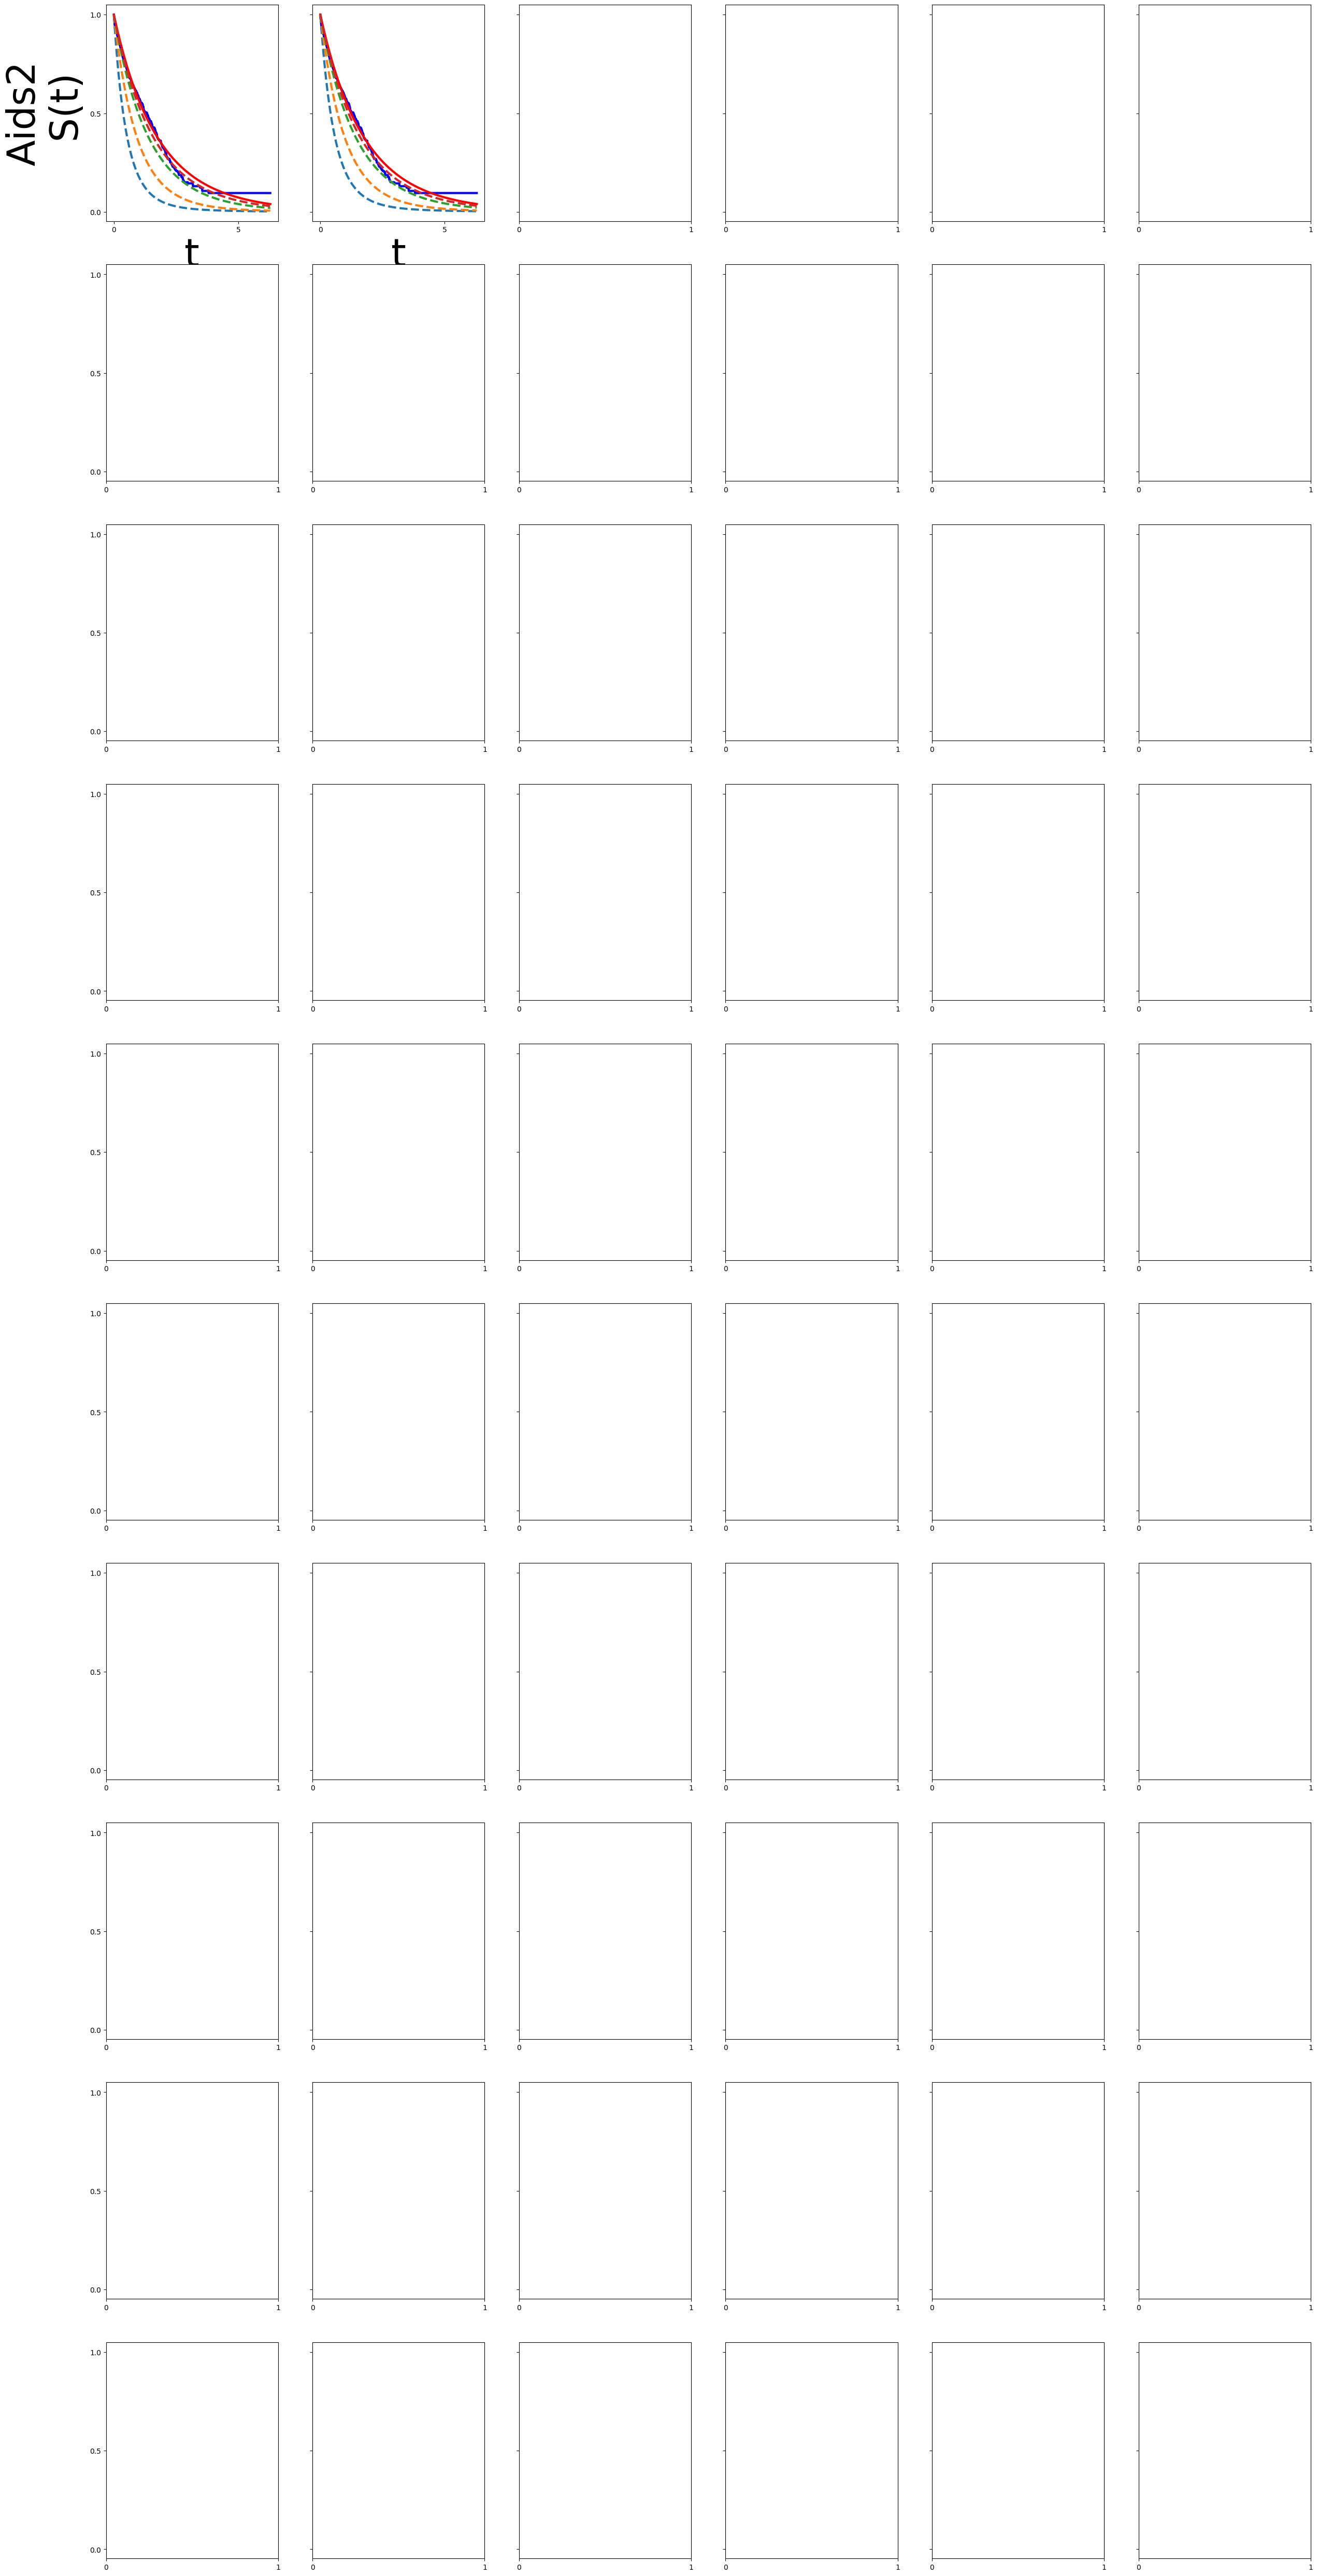

In [63]:
fig,axes = plt.subplots(n_rows,n_cols,figsize=(30,64),sharey=True)

SMALL_SIZE = 80
plt.rc('xtick', labelsize=SMALL_SIZE//2)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE//2)  
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)     # fontsize of the x and y labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)   # fontsize of the figure title


for i,key_dataset in enumerate(data_dict.keys()):
    for j,key_al in enumerate(algorithms):
        print(i,j)


        df_population = deepcopy(data_dict[key_dataset][key_al][seed_interest])

        t = df_population.pop("t")
        base_models = df_population.iloc[:,:2]
        base_models.columns = [col.split("_")[0] for col in base_models.columns]
        base_models = base_models.rename(columns={"kmf":"KMC","St":"NN"})
        
        df_population= df_population.iloc[:,2:].iloc[:,-5:-1]
        
        df_population.columns = ["$\epsilon$={:.2f}".format(eval(col.split("=")[1])) for col in df_population.columns]

        # print(base_models)
        base1 = axes[i][j].plot(t,base_models.iloc[:,0],linewidth=3,c="b")
        base2 = axes[i][j].plot(t,base_models.iloc[:,1],linewidth=3,c="r")
        perturb1 = axes[i][j].plot(t,df_population,'--',linewidth=3)
  
        if j == 0:
            # base1 = axes[i][j].plot(t,base_models.iloc[:,0],linewidth=3,c="b")
            # base2 = axes[i][j].plot(t,base_models.iloc[:,1],linewidth=3,c="r")
            # perturb = axes[i][j].plot(t,df_population,'--',linewidth=3)

            axes[i][j].set_ylabel(f"{key_dataset}\n S(t)" ,fontsize=SMALL_SIZE//1.5)
            axes[i][j].set_xlabel("t",fontsize=SMALL_SIZE//1.5)

        axes[i][j].set_xlabel("t",fontsize=SMALL_SIZE//1.5)

for ax, col in zip(axes[0], algorithms):
    col = "SAWAR" if col == "crownibp" else col
    col = "DRAFT" if col == "draft" else col
    col = "PGD" if col == "pgd" else col
    col = "FGSM" if col == "fgsm" else col
    col = "Noise" if col == "noise" else col
    col = "AAE-Cox" if col == "aae" else col

    ax.set_title(col,fontsize=SMALL_SIZE//1.5)

labels = base_models.columns.tolist() + df_population.columns.tolist()
# labels[labels.index("baseline")] = "non-robust"

fig.legend([base1, base2,perturb1], labels=labels, 
           loc="upper center",ncols=6,fontsize=30,bbox_to_anchor=(.5,1.03),prop={'size':SMALL_SIZE//1.7}) 

# axes[0][3].legend(base_models.columns.tolist() + robust_df.columns.tolist(),fontsize=20,ncol=2,loc=1)

# plt.legend(base_models.columns.tolist() + robust_df.columns.tolist(),loc='upper center',ncol=5)
plt.tight_layout(pad=0)
plt.savefig(save_folder,dpi=1600,bbox_inches="tight")
plt.show()

### DIST PLOTS

In [ ]:
attack = "fgsm"
excel_name = "curve_distributions_test.xlsx"
seed_interest = "222"

base_path = osp.join(os.getcwd(),"results")
attack_folder =  f"attack_{attack}"
seeds = [str(i*111) for i in range(1,6)]
results_folder = os.path.join(base_path, attack_folder)

algorithms = ["draft","noise","fgsm","pgd","aae","crownibp"]
exclude_datasets = ["Dialysis","divorce","Pbc3","vlbw"]

In [ ]:
data_dict = scrape_excel_data(results_folder,excel_name,seed_interest)

In [ ]:
data_dict['Aids2']['draft']

In [ ]:
n_rows = len(data_dict)
n_cols = len(data_dict["stagec"])

rename_dict = {"draft":"DRAFT","noise":"Noise","fgsm":"FGSM","pgd":"PGD","aae":"AAE-Cox","crownibp":"SAWAR"}

In [ ]:
cwd = os.getcwd()
save_folder = osp.join(cwd,"results",f"attack_{attack}","dist_curves.pdf")

In [ ]:
import seaborn as sns

In [ ]:
fig,axes = plt.subplots(n_rows,n_cols,figsize=(30,64),sharey=True)

SMALL_SIZE = 80
plt.rc('xtick', labelsize=SMALL_SIZE//2)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE//2)  
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)     # fontsize of the x and y labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)   # fontsize of the figure title


for i,key_dataset in enumerate(data_dict.keys()):
    for j,key_al in enumerate(algorithms):
        print(i,j)

        df_population = deepcopy(data_dict[key_dataset][key_al][seed_interest])

        t = df_population.pop("t")
                        
        mu = sns.lineplot(x=t, y=df_population.iloc[:,0], label='Average S(t)', linewidth=3.0, ax=axes[i][j],c='b',legend=False)
        q95 = sns.lineplot(x=t, y=df_population.iloc[:,1], label='Confidence', linewidth=3.0, ax=axes[i][j],c='r',legend=False)
        q05 = sns.lineplot(x=t, y=df_population.iloc[:,2], label='Confidence', linewidth=3.0, ax=axes[i][j],c='r',legend=False)

        line = q05.get_lines()
        axes[i][j].fill_between(line[0].get_xdata(), line[1].get_ydata(), line[2].get_ydata(), color='blue', alpha=.3)
        axes[i][j].set_xlabel("t",fontsize=SMALL_SIZE//1.5)

        if j == 0:
            axes[i][j].set_ylabel(f"{key_dataset}\n S(t)" ,fontsize=SMALL_SIZE//1.5)

for ax, col in zip(axes[0], algorithms):
    col = "SAWAR" if col == "crownibp" else col
    col = "DRAFT" if col == "draft" else col
    col = "PGD" if col == "pgd" else col
    col = "FGSM" if col == "fgsm" else col
    col = "Noise" if col == "noise" else col
    col = "AAE-Cox" if col == "aae" else col
    ax.set_title(col,fontsize=SMALL_SIZE//1.5)

labels = ["S(t)","Credible Interval","$Q_{95},Q_{05}$"]
fig.legend([mu,q95,q05], labels=labels, 
           loc="upper center",ncols=4,fontsize=30,bbox_to_anchor=(.5,1.05),prop={'size':SMALL_SIZE}) 

plt.tight_layout(pad=0)
plt.savefig(save_folder,dpi=1600,bbox_inches="tight")
plt.show()